In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls

drive  sample_data


In [9]:
%cd drive/MyDrive/비컴최

/content/drive/MyDrive/비컴최


In [10]:
!ls

test.csv  train.csv


In [11]:
import sys
print(sys.version)

3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [ ]:
!pip install -U torchtext==0.15.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import re
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# nlp library of Pytorch
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [6]:
# GPU 사용이 가능하면 사용하고, 그렇지 않으면 CPU를 사용합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
train_df = pd.read_csv("train.csv")
train_df.head()

,Category,Message
0,spam,Reply to win £100 weekly! Where will the 2006 ...
1,ham,Hello. Sort of out in town already. That . So ...
2,ham,How come guoyang go n tell her? Then u told her?
3,ham,Hey sathya till now we dint meet not even a si...
4,spam,Orange brings you ringtones from all time Char...


In [17]:
test_df = pd.read_csv("test.csv")
test_df.head()

,Category,Message
0,ham,Squeeeeeze!! This is christmas hug.. If u lik ...
1,ham,And also I've sorta blown him off a couple tim...
2,ham,Mmm thats better now i got a roast down me! i...
3,ham,Mm have some kanji dont eat anything heavy ok
4,ham,So there's a ring that comes with the guys cos...


In [18]:
max_features = 1000000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_df['Message'].values)
X = tokenizer.texts_to_sequences(train_df['Message'].values)
X = pad_sequences(X)
X

array([[   0,    0,    0, ...,    2,  316,  238],
       [   0,    0,    0, ...,    3,   53, 2604],
       [   0,    0,    0, ...,    6,  247,   99],
       ...,
       [   0,    0,    0, ...,  254,   31, 2486],
       [   0,    0,    0, ..., 1197,    1,  247],
       [   0,    0,    0, ...,    9, 3219, 1396]], dtype=int32)

In [19]:
TEXT = X
LABEL = np.where(train_df['Category']=='spam', 1, 0)

X_train, y_train = torch.tensor(X), torch.tensor(LABEL).to(float)

In [21]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, 
                init_states=None):
       
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
         
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # self.nums_of_str = nums_of_str
        self.embedding = nn.Embedding(max_features+1, 128)
        self.lstm = CustomLSTM(128,64)#nn.LSTM(64, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 1)
        
    def forward(self, x):
        x_ = self.embedding(x)
        x_, (h_n, c_n) = self.lstm(x_)
        x_ = (x_[:, -1, :])
        x_ = self.fc1(x_)
        return x_.sigmoid()

In [23]:
model = Net().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [24]:
ds_train = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)

In [25]:
from tqdm import tqdm
acc = 0
epoches = 25

losses = []
for epoch in tqdm(range(epoches)):
    print("epoch:", epoch)

    for i, (datapoints, labels) in enumerate(train_loader):
        datapoints = datapoints.long().to(device)
        labels = labels.float().to(device).reshape(-1,1)

        preds = model(datapoints)
        optimizer.zero_grad()
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
    print(f"\n{loss.detach().cpu().item()}")
    losses.append(loss.detach().cpu().item())

  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0


  4%|▍         | 1/25 [00:10<04:07, 10.31s/it]


0.18298682570457458
epoch: 1


  8%|▊         | 2/25 [00:17<03:18,  8.63s/it]


0.07351469248533249
epoch: 2


 12%|█▏        | 3/25 [00:25<02:56,  8.04s/it]


0.002258189721032977
epoch: 3


 16%|█▌        | 4/25 [00:32<02:41,  7.67s/it]


0.0018820894183591008
epoch: 4


 20%|██        | 5/25 [00:39<02:29,  7.49s/it]


0.00045143647002987564
epoch: 5


 24%|██▍       | 6/25 [00:46<02:21,  7.44s/it]


0.0002895586658269167
epoch: 6


 28%|██▊       | 7/25 [00:53<02:12,  7.37s/it]


0.00011264972999924794
epoch: 7


 32%|███▏      | 8/25 [01:01<02:04,  7.31s/it]


0.0004421945195645094
epoch: 8


 36%|███▌      | 9/25 [01:08<01:55,  7.25s/it]


8.425444684689865e-05
epoch: 9


 40%|████      | 10/25 [01:15<01:47,  7.20s/it]


0.00018336248467676342
epoch: 10


 44%|████▍     | 11/25 [01:22<01:40,  7.17s/it]


0.00010087096597999334
epoch: 11


 48%|████▊     | 12/25 [01:29<01:33,  7.17s/it]


5.506847082870081e-05
epoch: 12


 52%|█████▏    | 13/25 [01:36<01:26,  7.19s/it]


4.28477069362998e-05
epoch: 13


 56%|█████▌    | 14/25 [01:43<01:18,  7.15s/it]


8.095804514596239e-05
epoch: 14


 60%|██████    | 15/25 [01:51<01:11,  7.16s/it]


0.00023219455033540726
epoch: 15


 64%|██████▍   | 16/25 [01:58<01:04,  7.15s/it]


7.332422683248296e-05
epoch: 16


 68%|██████▊   | 17/25 [02:05<00:57,  7.16s/it]


4.9127134843729436e-05
epoch: 17


 72%|███████▏  | 18/25 [02:12<00:50,  7.15s/it]


6.23090672888793e-05
epoch: 18


 76%|███████▌  | 19/25 [02:19<00:42,  7.13s/it]


2.4622009732411243e-05
epoch: 19


 80%|████████  | 20/25 [02:26<00:36,  7.20s/it]


8.984593296190724e-05
epoch: 20


 84%|████████▍ | 21/25 [02:34<00:28,  7.19s/it]


1.893322951218579e-05
epoch: 21


 88%|████████▊ | 22/25 [02:41<00:21,  7.18s/it]


1.744163819239475e-05
epoch: 22


 92%|█████████▏| 23/25 [02:48<00:14,  7.18s/it]


3.0155531931086443e-05
epoch: 23


 96%|█████████▌| 24/25 [02:55<00:07,  7.17s/it]


2.039846367551945e-05
epoch: 24


100%|██████████| 25/25 [03:02<00:00,  7.31s/it]


2.1099553123349324e-05


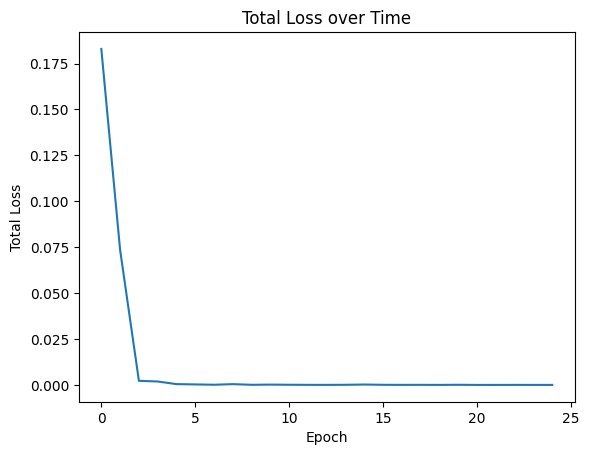

In [26]:
import matplotlib.pyplot as plt

# Assume that you have a list of total losses from your training loop
# total_losses = losses.detach().cpu().item()
total_losses = losses
# print(total_losses)
# Create a new figure and axis for the plot
fig, ax = plt.subplots()

# Plot the total losses
ax.plot(total_losses)

# Set the title and axis labels
ax.set_title('Total Loss over Time')
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Loss')

# Show the plot
plt.show()

In [27]:
test_df = pd.read_csv("test.csv")
test_df.head()

# 전처리와 동일한 방식으로 텍스트를 숫자 sequence로 변환
test_X = tokenizer.texts_to_sequences(test_df['Message'].values)
test_X = pad_sequences(test_X)

# 텐서로 변환
X_test = torch.tensor(test_X).to(device)

# 모델의 출력값 계산
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# 출력값 확인
print(y_pred)


tensor([[2.0532e-06],
        [1.0297e-03],
        [5.0722e-06],
        ...,
        [3.0464e-06],
        [4.1165e-06],
        [2.7913e-01]], device='cuda:0')


In [40]:
# 임계값 설정
threshold = 0.5
cnt = 0
# 확률값을 기준으로 spam 또는 ham으로 분류하고 메시지와 함께 출력
for message, label in zip(test_df['Message'], y_pred_labels):
  if cnt == 30:
    break
  else:
    if label == 1:
        print("- Prediction Output: spam","Message:", message)
        cnt +=1
    else:
        print("- Prediction Output : ham","Message:", message)
        cnt +=1



- Prediction Output : ham Message: Squeeeeeze!! This is christmas hug.. If u lik my frndshp den hug me back.. If u get 3 u r cute:) 6 u r luvd:* 9 u r so lucky;) None? People hate u:
- Prediction Output : ham Message: And also I've sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed
- Prediction Output : ham Message: Mmm thats better now i got a roast down me! id b better if i had a few drinks down me 2! Good indian?
- Prediction Output : ham Message: Mm have some kanji dont eat anything heavy ok
- Prediction Output : ham Message: So there's a ring that comes with the guys costumes. It's there so they can gift their future yowifes. Hint hint
- Prediction Output : ham Message: Sary just need Tim in the bollox &it hurt him a lot so he tol me!
- Prediction Output : ham Message: Love isn't a decision, it's a feeling. If we could decide who to love, then, life would be much simpler, but then less magical
- Prediction Output : ham Message: 